In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

In [2]:
train_path_dir = 'C:/ZhangLI/Codes/DataSet/kdd2020/underexpose_train/' 
test_path_dir = 'C:/ZhangLI/Codes/DataSet/kdd2020/underexpose_test/'

In [3]:
train_user_df = pd.read_csv(f'{train_path_dir}underexpose_user_feat.csv', names=['user_id','user_age_level','user_gender','user_city_level'])
train_item_df = pd.read_csv(f'{train_path_dir}underexpose_item_feat.csv')
train_click_0_df = pd.read_csv(f'{train_path_dir}underexpose_train_click-0.csv', names=['user_id','item_id','time'])

In [66]:
# pd.read_csv(f'{train_path_dir}underexpose_train_click-0.csv')

In [16]:

print('all_data占据内存约: {:.2f} MB'.format(train_click_0_df.memory_usage().sum()/ (1024**2)))


all_data占据内存约: 5.53 MB


<AxesSubplot:title={'center':'city'}>

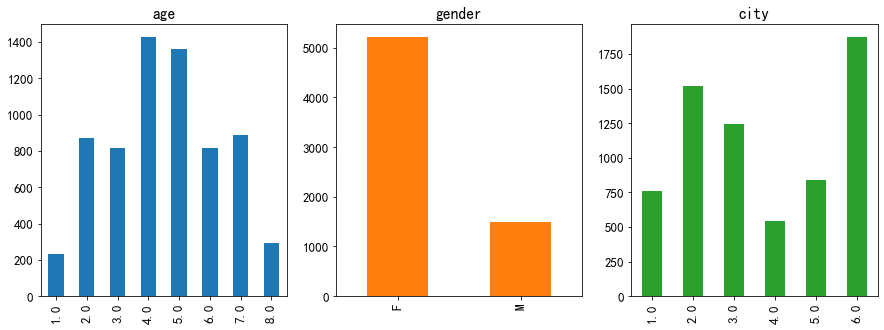

In [33]:
# ‘line' : line plot (default)#折线图
# ‘bar' : vertical bar plot#条形图
# ‘barh' : horizontal bar plot#横向条形图
# ‘hist' : histogram#柱状图
# ‘box' : boxplot#箱线图
# ‘kde' : Kernel Density Estimation plot#Kernel 的密度估计图，主要对柱状图添加Kernel 概率密度线
# ‘density' : same as ‘kde'
# ‘area' : area plot#不了解此图
# ‘pie' : pie plot#饼图
# ‘scatter' : scatter plot#散点图 需要传入columns方向的索引
# ‘hexbin' : hexbin plot#不了解此图

fig, ax = plt.subplots(1, 3, figsize=(15,5))
train_user_df['user_age_level'].value_counts().sort_index().plot(kind='bar', color=next(color_cycle), title='age', ax=ax[0])
train_user_df['user_gender'].value_counts().plot(kind='bar', color=next(color_cycle), title='gender', ax=ax[1])
train_user_df['user_city_level'].value_counts().sort_index().plot(kind='bar', color=next(color_cycle), title='city', ax=ax[2])

In [51]:
# 重复数据 value_counts()
train_user_df.shape
# 23453    2
# 32152    2
# 14818    2
train_user_df['user_id'].value_counts(ascending=False)

23453    2
32152    2
14818    2
21295    1
13139    1
        ..
4388     1
1498     1
7641     1
21976    1
18431    1
Name: user_id, Length: 6786, dtype: int64

In [58]:
# train_item_df
train_item_df.columns = ['item_id'] + ['txt_vec' + str(i) for i in range(128)] + ['img_vec'+str(i) for i in range(128)]
train_item_df['txt_vec0'] = train_item_df['txt_vec0'].apply(lambda x:float(x[1:]))
train_item_df['txt_vec127'] = train_item_df['txt_vec127'].apply(lambda x:float(x[:-1]))
train_item_df['img_vec0'] = train_item_df['img_vec0'].apply(lambda x:float(x[1:]))
train_item_df['img_vec127'] = train_item_df['img_vec127'].apply(lambda x:float(x[:-1]))

In [79]:
# train_clik_0_df
train_item_df.item_id.value_counts()
# test_user = train_click_0_df[train_click_0_df.user_id==4965]
train_click_0_df['rank'] = train_click_0_df.groupby(['user_id'])['time'].rank(ascending=False).astype(int)
train_click_0_df['click_cnts'] = train_click_0_df.groupby(['user_id'])['time'].transform('count')


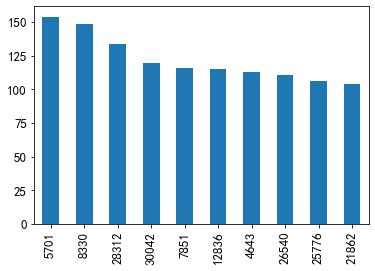

In [96]:
# 用户点击次数
train_click_0_df.user_id.value_counts()[:10].plot(kind='bar')
# 用户重复点击一个商品 -> 没有用户重复点击过一个商品
user_click = train_click_0_df.groupby(['user_id', 'item_id'])['time'].agg({'count'}).reset_index()
# 商品共现，点击某个商品后再点击另一个商品的概率
tmp = train_click_0_df.sort_values('time')
tmp['next_item'] = tmp.groupby(['user_id'])['item_id'].transform(lambda x: x.shift(-1))
tmp.groupby(['item_id', 'next_item'])['time'].agg({'count'}).reset_index().sort_values('count', ascending=False)

In [114]:
# 点击与商品文本描述关联， 发现有些商品没有描述向量
tmp = train_click_0_df[train_click_0_df['user_id']==5701]
tmp = tmp.merge(train_item_df, on='item_id', how='left')

In [131]:
# 相似性分析：分析用户的点击序列
tmp = tmp[tmp['txt_vec0'].notna()]
emb1 = tmp.values[1][-128-128:-128]
emb2 = tmp.values[1+1][-128-128:-128]
np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2)))  # np.linalg.norm(emb1)  # 21.32961305319845  np.sqrt(np.sum(np.power(emb1, 2)))




21.32961305319845

In [151]:
# 商品嵌入表示
# 图嵌入的方式表示
tmp = train_click_0_df.sort_values('time')
# 用户点击序列，构建文本
doc = tmp.groupby(['user_id'])['item_id'].agg({list}).reset_index()['list'].values.tolist()


In [148]:
doc['list'][0] = [str(i) for i in doc['list'][0]]

In [153]:
# 转为字符串
from gensim.models import Word2Vec

for i in range(len(doc)):
    doc[i] = [str(x) for x in doc[i]]

In [155]:
model = Word2Vec(doc, size=128, window=5, min_count=3, sg=0, hs=1, seed=2020)

In [166]:
values = set(tmp['item_id'].values)
w2v = []

In [173]:
# 获取每个item对应的编码
for v in values:
    try:
        a = [int(v)]
        a.extend(model[str(v)])
        w2v.append(a)
    except:
        pass
out_df = pd.DataFrame(w2v)
out_df.columns = ['item_id'] + ['item_vec'+str(i) for i in range(128)]

In [174]:
out_df

,item_id,item_vec0,item_vec1,item_vec2,item_vec3,item_vec4,item_vec5,item_vec6,item_vec7,item_vec8,...,item_vec118,item_vec119,item_vec120,item_vec121,item_vec122,item_vec123,item_vec124,item_vec125,item_vec126,item_vec127
0,1,0.038972,-0.014951,0.013827,0.089557,0.014466,0.010080,-0.085658,-0.035796,0.051338,...,0.081518,0.063311,-0.044583,-0.076269,-0.132286,0.044129,0.036804,-0.151380,-0.044969,0.054034
1,1,0.038972,-0.014951,0.013827,0.089557,0.014466,0.010080,-0.085658,-0.035796,0.051338,...,0.081518,0.063311,-0.044583,-0.076269,-0.132286,0.044129,0.036804,-0.151380,-0.044969,0.054034
2,2,-0.017235,-0.037751,-0.003779,-0.002013,0.001890,0.027198,0.018458,0.002782,0.003317,...,-0.006822,0.017514,0.024426,-0.005159,0.002501,0.005043,-0.012998,0.018046,0.015420,-0.002404
3,3,-0.001798,-0.025111,-0.023162,0.020721,0.001693,0.026597,0.007912,-0.025874,0.050171,...,0.041040,0.069449,-0.028618,-0.041895,-0.055841,0.041043,-0.003559,-0.066240,-0.048540,-0.006722
4,9,0.024775,0.003293,-0.007312,0.103657,0.010316,-0.029647,0.008513,-0.093452,0.066232,...,-0.008371,0.033249,0.008806,-0.020468,-0.045086,-0.011557,-0.017904,0.035833,-0.019257,-0.002185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79951,117235,0.028380,-0.014771,-0.000386,0.072676,0.020255,-0.000110,-0.053101,-0.028990,0.037958,...,0.025033,0.008584,-0.015179,-0.024923,-0.075001,-0.021186,0.034887,-0.025539,-0.024626,0.017927
79952,117244,-0.014694,-0.010772,-0.010627,-0.049259,-0.017221,0.016619,0.048185,0.011120,-0.000799,...,-0.002578,0.081871,-0.022590,-0.016879,0.012904,0.064310,-0.028870,-0.062968,-0.019225,0.012975
79953,117266,0.008939,0.010325,0.011403,0.003103,-0.015346,-0.017054,0.009807,-0.010040,-0.000721,...,-0.008742,0.006973,-0.007292,-0.013221,0.000295,0.013606,-0.011908,-0.013622,0.003187,0.010257
79954,117270,0.005672,-0.033633,0.006222,0.036886,0.008284,0.012586,-0.041565,0.009167,0.007694,...,0.028113,0.030691,-0.018872,-0.034692,-0.058454,0.020889,0.027246,-0.061175,-0.011238,0.047873


In [180]:
tmp = train_click_0_df[train_click_0_df['user_id']==5701]
tmp = tmp.merge(out_df, on='item_id', how='left')
nonull_tmp  = tmp[~tmp['item_vec0'].isnull()]

In [181]:
nonull_tmp

,user_id,item_id,time,rank,click_cnts,item_vec0,item_vec1,item_vec2,item_vec3,item_vec4,...,item_vec118,item_vec119,item_vec120,item_vec121,item_vec122,item_vec123,item_vec124,item_vec125,item_vec126,item_vec127
0,5701,14405,0.983930,71,154,-0.009708,-0.103826,-0.000825,0.045397,0.024983,...,0.055855,0.057207,0.012235,-0.053674,-0.093068,0.027638,0.037713,-0.085353,0.018328,0.046197
1,5701,14405,0.983930,71,154,-0.009708,-0.103826,-0.000825,0.045397,0.024983,...,0.055855,0.057207,0.012235,-0.053674,-0.093068,0.027638,0.037713,-0.085353,0.018328,0.046197
2,5701,53909,0.983931,60,154,-0.005482,0.037864,0.020528,-0.070646,0.000781,...,-0.021741,-0.088045,-0.012248,0.048021,0.056099,-0.033507,0.054982,0.033615,0.024848,0.037521
3,5701,53909,0.983931,60,154,-0.005482,0.037864,0.020528,-0.070646,0.000781,...,-0.021741,-0.088045,-0.012248,0.048021,0.056099,-0.033507,0.054982,0.033615,0.024848,0.037521
4,5701,90974,0.983931,62,154,-0.000417,-0.023049,0.017559,0.006808,0.012233,...,-0.008877,-0.031622,0.013905,0.008032,-0.008330,-0.016477,0.036317,-0.003350,0.029653,0.035004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,5701,93858,0.983888,93,154,0.035247,0.082875,-0.063924,0.157173,0.011422,...,0.037767,0.035950,-0.049748,-0.023334,-0.095928,-0.040398,-0.054582,0.088943,-0.144746,-0.131671
306,5701,100813,0.983955,14,154,0.021351,0.030306,0.013129,0.014085,0.000795,...,0.037427,-0.013889,-0.024542,-0.021480,-0.043053,0.016172,0.022924,-0.060185,-0.022801,-0.009594
307,5701,100813,0.983955,14,154,0.021351,0.030306,0.013129,0.014085,0.000795,...,0.037427,-0.013889,-0.024542,-0.021480,-0.043053,0.016172,0.022924,-0.060185,-0.022801,-0.009594
308,5701,108682,0.983955,31,154,0.035669,0.012700,0.003266,0.037723,0.014324,...,0.075608,0.070052,-0.055314,-0.051760,-0.111617,0.030247,0.037835,-0.141754,-0.070971,0.050337


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

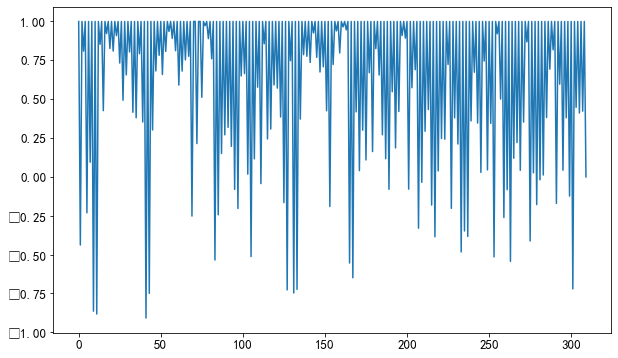

In [194]:
# 可以看点击物品的相似性
nonull_tmp = nonull_tmp.sort_values('time')
nonull_tmp
sim_list = []
for i in range(0, nonull_tmp.shape[0]-1):
    emb1 = nonull_tmp.values[i][-128:]
    emb2 = nonull_tmp.values[i+1][-128:]
    sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
sim_list.append(0)
sim_list
plt.figure()
plt.figure(figsize=(10, 6))
sns.lineplot(x=[i for i in range(len(sim_list))], y=sim_list)